In [336]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

le = LabelEncoder()


data_df = pd.read_csv('sequential.csv')
columns_drop = ['label','vv','Unnamed: 0']
data_df = data_df.drop(columns = columns_drop)

le_stn4contest = LabelEncoder()
le_ef_month = LabelEncoder()
le_class_interval = LabelEncoder()
le_ef_year = LabelEncoder()
le_ef_day = LabelEncoder()
le_ef_hour = LabelEncoder()
# Encode categorical columns
data_df['stn4contest'] = le_stn4contest.fit_transform(data_df['stn4contest'])
data_df['ef_month'] = le_ef_month.fit_transform(data_df['ef_month'])
data_df['ef_year'] = le_ef_month.fit_transform(data_df['ef_year'])
data_df['class_interval'] = le_class_interval.fit_transform(data_df['class_interval'])
data_df['ef_hour'] =le_ef_hour.fit_transform(data_df['ef_hour'])
data_df['ef_day'] = le_ef_day.fit_transform(data_df['ef_day'])
scaler_std = RobustScaler()
std_scale_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09'] # dh는 scale하지 말자 => 정보 손실
data_df['dh']= data_df['dh']/ 240

In [337]:
prob_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09','dh']
index_column = ['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']
num_agg = data_df.groupby(index_column)[prob_column].agg(['mean', 'min', 'max', 'first','std'])
num_agg.columns = ['_'.join(x) for x in num_agg.columns]
first_df = data_df.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']).head(1)
num_agg.index= first_df.index

In [338]:
num_agg['ef_month'] = first_df['ef_month']
num_agg['ef_hour'] = first_df['ef_hour']
num_agg['ef_day'] = first_df['ef_day']



In [339]:
num_agg['diff1']=num_agg['v01_first']-num_agg['v02_first']
num_agg['diff2']=num_agg['v02_first']-num_agg['v03_first']
num_agg['diff3']=num_agg['v03_first']-num_agg['v04_first']
num_agg['diff4']=num_agg['v04_first']-num_agg['v05_first']
num_agg['diff5']=num_agg['v05_first']-num_agg['v06_first']
num_agg['diff6']=num_agg['v06_first']-num_agg['v07_first']
num_agg['diff7']=num_agg['v07_first']-num_agg['v08_first']
num_agg['diff8']=num_agg['v08_first']-num_agg['v09_first']

In [350]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from xgboost import XGBClassifier
XGboost = XGBClassifier(random_state=42)
X = num_agg
X = X.fillna(0)
y = first_df['class_interval']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [265]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score

y_pred = XGboost.predict(X_test)
def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted') 

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
clf_eval(y_pred,y_test)

Accuracy: 0.854821025475653
Precision: 0.7968932107838251
Recall: 0.854821025475653


0.10461416070007955

XGBOOST

In [266]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split

def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf


def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate, 
        subsample=subsample, 
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Predict the validation set results
    y_pred = clf.predict(X_val)
    
    # Calculate the score using your custom function
    score = clf_eval(y_pred, y_val)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) 

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-06-18 16:34:35,415] A new study created in memory with name: no-name-5016e256-efd5-4d34-8874-99552b7f7914
[W 2024-06-18 16:34:44,535] Trial 0 failed with parameters: {'n_estimators': 45, 'max_depth': 15.194827866638036, 'learning_rate': 0.05521607591362552, 'subsample': 0.3659352585683727, 'colsample_bytree': 0.625797594841241} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\1762822784.py", line 35, in objective
    clf.fit(X_train, y_train)
  File "c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
  File "c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
  File "c:\Users\dochy\anaconda3\env

KeyboardInterrupt: 

Randomforest Classifier

In [245]:
from sklearn.ensemble import RandomForestClassifier

import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split

def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf


def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Predict the validation set results
    y_pred = clf.predict(X_val)
    
    # Calculate the score using your custom function
    score = clf_eval(y_pred, y_val)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-06-18 13:49:42,717] A new study created in memory with name: no-name-f1d599ad-ff45-415b-9f13-af7b9fa53ab0
[I 2024-06-18 13:49:44,890] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 100, 'max_depth': 1.612720024117922}. Best is trial 0 with value: 0.0.
[I 2024-06-18 13:49:47,503] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 123, 'max_depth': 1.0594253277918575}. Best is trial 0 with value: 0.0.
[I 2024-06-18 13:49:48,503] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 46, 'max_depth': 1.6068170792966765}. Best is trial 0 with value: 0.0.
[I 2024-06-18 13:50:15,994] Trial 3 finished with value: 0.1128184391427416 and parameters: {'n_estimators': 89, 'max_depth': 22.027833560296425}. Best is trial 3 with value: 0.1128184391427416.
[I 2024-06-18 13:50:30,007] Trial 4 finished with value: 0.11518324607329843 and parameters: {'n_estimators': 44, 'max_depth': 28.9221631049326}. Best is trial 4 with value: 0.11518324607329843.


Score: 0.12075928917609047
Best hyperparameters: {'n_estimators': 111, 'max_depth': 24.55873821011928}


In [243]:
# Catboost
import optuna
X = num_agg
y = first_df['class_interval']

from catboost import CatBoostClassifier

def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf


def objective(trial):
    iterations = trial.suggest_int('iterations', 100, 500)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    
    clf = CatBoostClassifier(iterations=iterations, depth=depth, learning_rate=learning_rate, verbose=False)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Predict the validation set results
    y_pred = clf.predict(X_val)
    
    # Calculate the score using your custom function
    score = clf_eval(y_pred, y_val)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-06-20 17:30:47,723] A new study created in memory with name: no-name-ef189547-3881-4e4f-9b76-18a7e644eab5
[I 2024-06-20 17:33:02,595] Trial 0 finished with value: 0.11079429735234216 and parameters: {'iterations': 334, 'depth': 9, 'learning_rate': 0.029622471531392865}. Best is trial 0 with value: 0.11079429735234216.
[I 2024-06-20 17:35:00,241] Trial 1 finished with value: 0.12530024019215372 and parameters: {'iterations': 471, 'depth': 8, 'learning_rate': 0.16448147960916087}. Best is trial 1 with value: 0.12530024019215372.
[I 2024-06-20 17:35:15,729] Trial 2 finished with value: 0.10953346855983773 and parameters: {'iterations': 355, 'depth': 5, 'learning_rate': 0.13777762863708296}. Best is trial 1 with value: 0.12530024019215372.
[I 2024-06-20 17:35:26,832] Trial 3 finished with value: 0.11282467532467533 and parameters: {'iterations': 318, 'depth': 4, 'learning_rate': 0.19646067810486417}. Best is trial 1 with value: 0.12530024019215372.
[I 2024-06-20 17:37:27,292] Trial

KeyboardInterrupt: 

In [247]:
# LGBM
import lightgbm as lgb


def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf


def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 100)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    
    clf = lgb.LGBMClassifier(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Predict the validation set results
    y_pred = clf.predict(X_val)
    
    # Calculate the score using your custom function
    score = clf_eval(y_pred, y_val)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-06-18 15:14:21,752] A new study created in memory with name: no-name-c5d56435-4572-4c0e-b473-434574284b45


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:14:24,051] Trial 0 finished with value: 0.08734330772341285 and parameters: {'num_leaves': 68, 'max_depth': 17, 'learning_rate': 0.07925006259340986, 'n_estimators': 34}. Best is trial 0 with value: 0.08734330772341285.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:14:27,841] Trial 1 finished with value: 0.0983739837398374 and parameters: {'num_leaves': 94, 'max_depth': 14, 'learning_rate': 0.052335110684708974, 'n_estimators': 48}. Best is trial 1 with value: 0.0983739837398374.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-18 15:14:32,025] Trial 2 finished with value: 0.09150061000406669 and parameters: {'num_leaves': 51, 'max_depth': 14, 'learning_rate': 0.05026678072512861, 'n_estimators': 84}. Best is trial 1 with value: 0.0983739837398374.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:14:37,918] Trial 3 finished with value: 0.10517733387688545 and parameters: {'num_leaves': 93, 'max_depth': 44, 'learning_rate': 0.03893134640530612, 'n_estimators': 77}. Best is trial 3 with value: 0.10517733387688545.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:14:42,808] Trial 4 finished with value: 0.10828025477707007 and parameters: {'num_leaves': 78, 'max_depth': 35, 'learning_rate': 0.09438534554540906, 'n_estimators': 72}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 15:14:45,235] Trial 5 finished with value: 0.09202453987730061 and parameters: {'num_leaves': 68, 'max_depth': 6, 'learning_rate': 0.06495476793806328, 'n_estimators': 55}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 15:14:48,120] Trial 6 finished with value: 0.09283387622149837 and parameters: {'num_leaves': 81, 'max_depth': 10, 'learning_rate': 0.059244646196194406, 'n_estimators': 41}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:14:53,549] Trial 7 finished with value: 0.10298869143780291 and parameters: {'num_leaves': 71, 'max_depth': 40, 'learning_rate': 0.053680024393097346, 'n_estimators': 85}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:14:56,166] Trial 8 finished with value: 0.09605209605209605 and parameters: {'num_leaves': 50, 'max_depth': 29, 'learning_rate': 0.06044529927990747, 'n_estimators': 49}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:14:57,217] Trial 9 finished with value: 0.057947019867549666 and parameters: {'num_leaves': 50, 'max_depth': 28, 'learning_rate': 0.06732962617464922, 'n_estimators': 17}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:14:59,417] Trial 10 finished with value: 0.09814963797264682 and parameters: {'num_leaves': 18, 'max_depth': 37, 'learning_rate': 0.09619341317296258, 'n_estimators': 70}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:04,911] Trial 11 finished with value: 0.08774834437086093 and parameters: {'num_leaves': 97, 'max_depth': 50, 'learning_rate': 0.021934574917414795, 'n_estimators': 71}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:12,057] Trial 12 finished with value: 0.10785510785510785 and parameters: {'num_leaves': 84, 'max_depth': 50, 'learning_rate': 0.030129596111008426, 'n_estimators': 100}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:15,980] Trial 13 finished with value: 0.03147293327738145 and parameters: {'num_leaves': 35, 'max_depth': 49, 'learning_rate': 0.010547556673864679, 'n_estimators': 95}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:22,977] Trial 14 finished with value: 0.10596833130328867 and parameters: {'num_leaves': 81, 'max_depth': 33, 'learning_rate': 0.03443747874052383, 'n_estimators': 100}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:27,536] Trial 15 finished with value: 0.1076861489191353 and parameters: {'num_leaves': 81, 'max_depth': 21, 'learning_rate': 0.08335853539826717, 'n_estimators': 65}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:32,725] Trial 16 finished with value: 0.1000408329930584 and parameters: {'num_leaves': 61, 'max_depth': 43, 'learning_rate': 0.03656244397892593, 'n_estimators': 88}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:35,421] Trial 17 finished with value: 0.07759336099585062 and parameters: {'num_leaves': 33, 'max_depth': 36, 'learning_rate': 0.02482802057142989, 'n_estimators': 64}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:36,175] Trial 18 finished with value: 0.09278350515463918 and parameters: {'num_leaves': 8, 'max_depth': 24, 'learning_rate': 0.09978875681907731, 'n_estimators': 24}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:42,930] Trial 19 finished with value: 0.10136217948717949 and parameters: {'num_leaves': 86, 'max_depth': 46, 'learning_rate': 0.07753016688483252, 'n_estimators': 93}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2024-06-18 15:15:44,240] Trial 20 finished with value: 0.09094650205761316 and parameters: {'num_leaves': 100, 'max_depth': 1, 'learning_rate': 0.09075241049528651, 'n_estimators': 78}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-18 15:15:48,313] Trial 21 finished with value: 0.10682730923694779 and parameters: {'num_leaves': 76, 'max_depth': 19, 'learning_rate': 0.08492031287390232, 'n_estimators': 61}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:52,726] Trial 22 finished with value: 0.09903769045709704 and parameters: {'num_leaves': 88, 'max_depth': 23, 'learning_rate': 0.07096592999855307, 'n_estimators': 63}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:15:57,073] Trial 23 finished with value: 0.10084033613445378 and parameters: {'num_leaves': 59, 'max_depth': 32, 'learning_rate': 0.08610387758441052, 'n_estimators': 76}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:01,066] Trial 24 finished with value: 0.09775967413441955 and parameters: {'num_leaves': 79, 'max_depth': 22, 'learning_rate': 0.04497530820773914, 'n_estimators': 57}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:05,179] Trial 25 finished with value: 0.10511478050745067 and parameters: {'num_leaves': 62, 'max_depth': 38, 'learning_rate': 0.07390402040048946, 'n_estimators': 69}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:12,646] Trial 26 finished with value: 0.10436507936507937 and parameters: {'num_leaves': 88, 'max_depth': 28, 'learning_rate': 0.0914649521034851, 'n_estimators': 100}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:15,965] Trial 27 finished with value: 0.10028078620136383 and parameters: {'num_leaves': 76, 'max_depth': 32, 'learning_rate': 0.08273314644940773, 'n_estimators': 48}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:18,706] Trial 28 finished with value: 0.0 and parameters: {'num_leaves': 87, 'max_depth': 40, 'learning_rate': 0.01065817465718795, 'n_estimators': 37}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:20,555] Trial 29 finished with value: 0.005887300252312868 and parameters: {'num_leaves': 71, 'max_depth': 16, 'learning_rate': 0.02117555250776903, 'n_estimators': 29}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:23,966] Trial 30 finished with value: 0.10164724789071916 and parameters: {'num_leaves': 37, 'max_depth': 20, 'learning_rate': 0.07890052870867048, 'n_estimators': 80}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:28,131] Trial 31 finished with value: 0.10124049619847938 and parameters: {'num_leaves': 76, 'max_depth': 19, 'learning_rate': 0.0888081620704982, 'n_estimators': 62}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 15:16:31,681] Trial 32 finished with value: 0.10267678785457451 and parameters: {'num_leaves': 73, 'max_depth': 11, 'learning_rate': 0.09487032673872464, 'n_estimators': 57}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:34,861] Trial 33 finished with value: 0.0996 and parameters: {'num_leaves': 65, 'max_depth': 26, 'learning_rate': 0.08376661002251087, 'n_estimators': 51}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:38,103] Trial 34 finished with value: 0.08863356585966352 and parameters: {'num_leaves': 92, 'max_depth': 17, 'learning_rate': 0.04578265923525509, 'n_estimators': 40}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 15:16:41,707] Trial 35 finished with value: 0.10043324143363529 and parameters: {'num_leaves': 57, 'max_depth': 12, 'learning_rate': 0.09921406034115263, 'n_estimators': 67}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 15:16:46,780] Trial 36 finished with value: 0.103420523138833 and parameters: {'num_leaves': 82, 'max_depth': 8, 'learning_rate': 0.07378773364883479, 'n_estimators': 88}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-06-18 15:16:51,430] Trial 37 finished with value: 0.10572687224669604 and parameters: {'num_leaves': 93, 'max_depth': 20, 'learning_rate': 0.08115373610275664, 'n_estimators': 60}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:54,142] Trial 38 finished with value: 0.06910907577019151 and parameters: {'num_leaves': 67, 'max_depth': 14, 'learning_rate': 0.03010957661692347, 'n_estimators': 43}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:16:57,895] Trial 39 finished with value: 0.10097323600973236 and parameters: {'num_leaves': 44, 'max_depth': 47, 'learning_rate': 0.06188710335835229, 'n_estimators': 76}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:02,423] Trial 40 finished with value: 0.09801539084649656 and parameters: {'num_leaves': 54, 'max_depth': 30, 'learning_rate': 0.056449893798554536, 'n_estimators': 84}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:09,199] Trial 41 finished with value: 0.10442909386428281 and parameters: {'num_leaves': 83, 'max_depth': 33, 'learning_rate': 0.033050922724433156, 'n_estimators': 95}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:15,963] Trial 42 finished with value: 0.10626262626262627 and parameters: {'num_leaves': 78, 'max_depth': 26, 'learning_rate': 0.049216915109198525, 'n_estimators': 100}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:22,157] Trial 43 finished with value: 0.09906617945594803 and parameters: {'num_leaves': 77, 'max_depth': 26, 'learning_rate': 0.044110914693475924, 'n_estimators': 92}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:25,698] Trial 44 finished with value: 0.09595753368721928 and parameters: {'num_leaves': 73, 'max_depth': 42, 'learning_rate': 0.05109731199813245, 'n_estimators': 53}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:31,238] Trial 45 finished with value: 0.102803738317757 and parameters: {'num_leaves': 92, 'max_depth': 18, 'learning_rate': 0.04093373380518789, 'n_estimators': 73}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-18 15:17:36,218] Trial 46 finished with value: 0.10390656463954893 and parameters: {'num_leaves': 68, 'max_depth': 15, 'learning_rate': 0.06728722318079908, 'n_estimators': 83}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:37,216] Trial 47 finished with value: 0.06606483381206402 and parameters: {'num_leaves': 97, 'max_depth': 24, 'learning_rate': 0.09486605934828242, 'n_estimators': 10}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:43,575] Trial 48 finished with value: 0.1076 and parameters: {'num_leaves': 83, 'max_depth': 35, 'learning_rate': 0.08733581634883084, 'n_estimators': 88}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:49,768] Trial 49 finished with value: 0.1057462090981644 and parameters: {'num_leaves': 82, 'max_depth': 35, 'learning_rate': 0.08947962235557845, 'n_estimators': 88}. Best is trial 4 with value: 0.10828025477707007.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:54,347] Trial 50 finished with value: 0.1106687898089172 and parameters: {'num_leaves': 88, 'max_depth': 46, 'learning_rate': 0.0857322595801244, 'n_estimators': 66}. Best is trial 50 with value: 0.1106687898089172.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:17:59,328] Trial 51 finished with value: 0.10654429369513169 and parameters: {'num_leaves': 85, 'max_depth': 45, 'learning_rate': 0.0869411768408252, 'n_estimators': 67}. Best is trial 50 with value: 0.1106687898089172.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:04,187] Trial 52 finished with value: 0.11377245508982035 and parameters: {'num_leaves': 100, 'max_depth': 40, 'learning_rate': 0.07640347478189921, 'n_estimators': 59}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:10,076] Trial 53 finished with value: 0.10591526778577139 and parameters: {'num_leaves': 98, 'max_depth': 48, 'learning_rate': 0.0758136165233606, 'n_estimators': 73}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:16,539] Trial 54 finished with value: 0.1036 and parameters: {'num_leaves': 95, 'max_depth': 41, 'learning_rate': 0.08032273707008561, 'n_estimators': 81}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:21,721] Trial 55 finished with value: 0.11070998796630566 and parameters: {'num_leaves': 90, 'max_depth': 50, 'learning_rate': 0.07033995577661092, 'n_estimators': 66}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:25,485] Trial 56 finished with value: 0.10256410256410256 and parameters: {'num_leaves': 90, 'max_depth': 44, 'learning_rate': 0.06962889299010303, 'n_estimators': 45}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:30,848] Trial 57 finished with value: 0.11049284578696343 and parameters: {'num_leaves': 99, 'max_depth': 50, 'learning_rate': 0.09321383093623678, 'n_estimators': 66}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:35,614] Trial 58 finished with value: 0.10219560878243512 and parameters: {'num_leaves': 98, 'max_depth': 49, 'learning_rate': 0.09263307164546042, 'n_estimators': 59}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:41,516] Trial 59 finished with value: 0.10496568429551877 and parameters: {'num_leaves': 100, 'max_depth': 46, 'learning_rate': 0.06258104067788049, 'n_estimators': 72}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:45,726] Trial 60 finished with value: 0.11119936457505956 and parameters: {'num_leaves': 90, 'max_depth': 50, 'learning_rate': 0.09906711966436188, 'n_estimators': 55}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:49,907] Trial 61 finished with value: 0.10445407962160032 and parameters: {'num_leaves': 90, 'max_depth': 50, 'learning_rate': 0.09693544566544662, 'n_estimators': 54}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:18:55,044] Trial 62 finished with value: 0.11142061281337047 and parameters: {'num_leaves': 95, 'max_depth': 50, 'learning_rate': 0.09306090772271183, 'n_estimators': 65}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:00,408] Trial 63 finished with value: 0.10390127388535032 and parameters: {'num_leaves': 94, 'max_depth': 48, 'learning_rate': 0.09275762362901392, 'n_estimators': 68}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:05,789] Trial 64 finished with value: 0.1078936929789766 and parameters: {'num_leaves': 100, 'max_depth': 39, 'learning_rate': 0.09799590099755522, 'n_estimators': 64}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:10,696] Trial 65 finished with value: 0.10982888977317946 and parameters: {'num_leaves': 90, 'max_depth': 43, 'learning_rate': 0.09414053138846562, 'n_estimators': 65}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:15,041] Trial 66 finished with value: 0.10298210735586481 and parameters: {'num_leaves': 89, 'max_depth': 43, 'learning_rate': 0.09098944965605832, 'n_estimators': 57}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:20,267] Trial 67 finished with value: 0.08966725043782837 and parameters: {'num_leaves': 95, 'max_depth': 46, 'learning_rate': 0.09584123402739915, 'n_estimators': 65}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:22,122] Trial 68 finished with value: 0.09681323114158935 and parameters: {'num_leaves': 25, 'max_depth': 50, 'learning_rate': 0.08506855499506899, 'n_estimators': 50}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:26,934] Trial 69 finished with value: 0.10604870384917518 and parameters: {'num_leaves': 96, 'max_depth': 48, 'learning_rate': 0.09966527462362981, 'n_estimators': 60}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:32,206] Trial 70 finished with value: 0.10796812749003984 and parameters: {'num_leaves': 91, 'max_depth': 44, 'learning_rate': 0.08882979090119307, 'n_estimators': 69}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:37,170] Trial 71 finished with value: 0.10250297973778308 and parameters: {'num_leaves': 86, 'max_depth': 47, 'learning_rate': 0.09383412852520022, 'n_estimators': 65}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:42,668] Trial 72 finished with value: 0.10322079937912301 and parameters: {'num_leaves': 88, 'max_depth': 42, 'learning_rate': 0.09672925835214374, 'n_estimators': 74}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:47,032] Trial 73 finished with value: 0.11039743075070253 and parameters: {'num_leaves': 94, 'max_depth': 45, 'learning_rate': 0.07753804047728304, 'n_estimators': 55}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:51,420] Trial 74 finished with value: 0.10522088353413654 and parameters: {'num_leaves': 93, 'max_depth': 50, 'learning_rate': 0.07729706216798889, 'n_estimators': 56}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:55,740] Trial 75 finished with value: 0.10393258426966293 and parameters: {'num_leaves': 100, 'max_depth': 44, 'learning_rate': 0.07234838246046421, 'n_estimators': 52}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:19:56,903] Trial 76 finished with value: 0.09447852760736196 and parameters: {'num_leaves': 6, 'max_depth': 46, 'learning_rate': 0.08203512125647028, 'n_estimators': 47}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:02,017] Trial 77 finished with value: 0.10787055533359968 and parameters: {'num_leaves': 96, 'max_depth': 48, 'learning_rate': 0.07532866983143169, 'n_estimators': 62}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:06,368] Trial 78 finished with value: 0.10526315789473684 and parameters: {'num_leaves': 85, 'max_depth': 45, 'learning_rate': 0.06670104378254255, 'n_estimators': 59}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:11,431] Trial 79 finished with value: 0.10420841683366733 and parameters: {'num_leaves': 80, 'max_depth': 40, 'learning_rate': 0.0783827784395291, 'n_estimators': 70}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:15,749] Trial 80 finished with value: 0.10595761695321872 and parameters: {'num_leaves': 91, 'max_depth': 49, 'learning_rate': 0.08694298071919626, 'n_estimators': 55}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:20,472] Trial 81 finished with value: 0.1053670086819258 and parameters: {'num_leaves': 87, 'max_depth': 38, 'learning_rate': 0.09102940752577296, 'n_estimators': 62}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:26,636] Trial 82 finished with value: 0.1051792828685259 and parameters: {'num_leaves': 93, 'max_depth': 47, 'learning_rate': 0.08425435845574379, 'n_estimators': 79}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:31,936] Trial 83 finished with value: 0.10850556438791734 and parameters: {'num_leaves': 95, 'max_depth': 42, 'learning_rate': 0.09329169039656049, 'n_estimators': 67}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:37,286] Trial 84 finished with value: 0.09948062325209749 and parameters: {'num_leaves': 98, 'max_depth': 42, 'learning_rate': 0.0935788936774944, 'n_estimators': 66}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:41,924] Trial 85 finished with value: 0.10444177671068428 and parameters: {'num_leaves': 95, 'max_depth': 45, 'learning_rate': 0.08898635757806152, 'n_estimators': 58}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:47,289] Trial 86 finished with value: 0.10492591109331198 and parameters: {'num_leaves': 91, 'max_depth': 49, 'learning_rate': 0.06986132211129963, 'n_estimators': 70}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:53,054] Trial 87 finished with value: 0.10648518815052041 and parameters: {'num_leaves': 89, 'max_depth': 43, 'learning_rate': 0.0813663730572794, 'n_estimators': 75}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:20:57,977] Trial 88 finished with value: 0.10103420843277645 and parameters: {'num_leaves': 97, 'max_depth': 47, 'learning_rate': 0.09790361475625253, 'n_estimators': 61}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:03,244] Trial 89 finished with value: 0.1091703056768559 and parameters: {'num_leaves': 100, 'max_depth': 41, 'learning_rate': 0.08556320220909631, 'n_estimators': 63}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:08,338] Trial 90 finished with value: 0.10346199761241544 and parameters: {'num_leaves': 98, 'max_depth': 49, 'learning_rate': 0.0848700141416278, 'n_estimators': 63}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:13,633] Trial 91 finished with value: 0.10707151418298043 and parameters: {'num_leaves': 94, 'max_depth': 41, 'learning_rate': 0.09470370386166069, 'n_estimators': 67}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:19,435] Trial 92 finished with value: 0.10828025477707007 and parameters: {'num_leaves': 100, 'max_depth': 38, 'learning_rate': 0.0910461940693584, 'n_estimators': 71}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:24,725] Trial 93 finished with value: 0.11035856573705179 and parameters: {'num_leaves': 93, 'max_depth': 45, 'learning_rate': 0.0877721972803834, 'n_estimators': 64}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:28,723] Trial 94 finished with value: 0.09759036144578313 and parameters: {'num_leaves': 84, 'max_depth': 45, 'learning_rate': 0.0792513638120527, 'n_estimators': 53}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:33,695] Trial 95 finished with value: 0.1088 and parameters: {'num_leaves': 92, 'max_depth': 46, 'learning_rate': 0.0878025154945689, 'n_estimators': 64}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:35,352] Trial 96 finished with value: 0.10092854259184497 and parameters: {'num_leaves': 12, 'max_depth': 50, 'learning_rate': 0.08361233908004365, 'n_estimators': 58}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:39,633] Trial 97 finished with value: 0.10688550840672538 and parameters: {'num_leaves': 87, 'max_depth': 44, 'learning_rate': 0.08596666909729252, 'n_estimators': 56}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:44,717] Trial 98 finished with value: 0.10870437224227839 and parameters: {'num_leaves': 98, 'max_depth': 48, 'learning_rate': 0.07670649428596191, 'n_estimators': 61}. Best is trial 52 with value: 0.11377245508982035.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


[I 2024-06-18 15:21:48,645] Trial 99 finished with value: 0.10168810289389067 and parameters: {'num_leaves': 90, 'max_depth': 41, 'learning_rate': 0.0741085122676736, 'n_estimators': 50}. Best is trial 52 with value: 0.11377245508982035.


Score: 0.11377245508982035
Best hyperparameters: {'num_leaves': 100, 'max_depth': 40, 'learning_rate': 0.07640347478189921, 'n_estimators': 59}


Multi layer perceptron

In [72]:
X = num_agg
y = first_df['class_interval']
X_drop = X.fillna(0)

In [73]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y_dnn = to_categorical(y.values)
X_dnn = X_drop.values
X_train, X_test, y_train, y_test = train_test_split(X_dnn, y_dnn, test_size=0.2, random_state=42)

In [6]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Define the DNN model
model = Sequential()
model.add(Dense(64, activation='tanh', input_dim=53))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # 20% dropout rate
model.add(Dense(32, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # 20% dropout rate
model.add(Dense(10, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2)

NameError: name 'X_train' is not defined

In [76]:
y_pred = model.predict(X_test)

485/485 [==============================] - 1s 1ms/step


In [81]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_class = np.argmax(y_pred,axis=1)
y_test_class = np.argmax(y_test,axis=1)


def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf


print("Accuracy: ", accuracy_score(y_test_class, y_pred_class))
print("Precision: ", precision_score(y_test_class, y_pred_class, average='weighted'))
print("Recall: ", recall_score(y_test_class, y_pred_class, average='weighted'))
print("F1 Score: ", f1_score(y_test_class, y_pred_class, average='weighted'))
# cm = confusion_matrix(y_test_class, y_pred_class)
# sns.heatmap(cm,annot=True,fmt ='d',cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

print(clf_eval(y_pred_class,y_test_class))


Accuracy:  0.8563044179297001
Precision:  0.776509840356415
Recall:  0.8563044179297001
F1 Score:  0.8132978529148565
0.09687880016214025


c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Import necessary libraries
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

X = X.values
Y = y.values

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=53))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # 20% dropout rate
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # 20% dropout rate
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X, Y, epochs=10, batch_size=128, verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X, Y, verbose=0)
print('Accuracy: %.2f' % (accuracy * 100))

In [344]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


best_rf_params = {'n_estimators': 111, 'max_depth': 25}
best_lgbm_params = {'num_leaves': 69, 'max_depth': 49, 'learning_rate': 0.07666414363854966, 'n_estimators': 96}
best_xgb_params = {'n_estimators': 98, 'max_depth': 14, 'learning_rate': 0.09892938180643206, 'subsample': 0.5863193004666019, 'colsample_bytree': 0.515216684370245}
best_cat_params = {'iterations': 455, 'depth': 10, 'learning_rate': 0.22728295299413886}

rf = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'], max_depth=best_rf_params['max_depth'])
lgbm = LGBMClassifier(num_leaves=best_lgbm_params['num_leaves'], max_depth=best_lgbm_params['max_depth'], learning_rate=best_lgbm_params['learning_rate'], n_estimators=best_lgbm_params['n_estimators'],force_row_wise=True)
xgb = XGBClassifier(n_estimators=best_xgb_params['n_estimators'], max_depth=best_xgb_params['max_depth'], learning_rate=best_xgb_params['learning_rate'], subsample=best_xgb_params['subsample'], colsample_bytree=best_xgb_params['colsample_bytree'])
cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'])

In [345]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf

In [268]:
rf.fit(X_train,y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train,y_train)
cat.fit(X_train,y_train) 

[LightGBM] [Info] Total Bins 7418
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 58
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
0:	learn: 0.8265895	total: 810ms	remaining: 3m 56s
1:	learn: 0.7184157	total: 1.52s	remaining: 3m 41s
2:	learn: 0.6485880	total: 2.24s	remaining: 3m 36s
3:	learn: 0.6011760	total: 3.03s	remaining: 3m 38s
4:	learn: 0.5694762	total: 3.74s	remaining: 3m 35s
5:	learn: 0.5455854	total: 4.45s	remaining: 3m 32s
6:	learn: 0.5277123	total: 

In [346]:
def model_evaluation(y_pred,y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted') 
    clf = clf_eval(y_pred,y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    return clf

In [269]:
# XGboost
y_pred = xgb.predict(X_test)
model_evaluation(y_pred,y_test)

Accuracy: 0.8568848758465011
Precision: 0.8001087254613206
Recall: 0.8568848758465011


0.11346384338793448

In [270]:
# Randomforest
y_pred = rf.predict(X_test)
model_evaluation(y_pred,y_test)

Accuracy: 0.8580457916801032
Precision: 0.7988107183606296
Recall: 0.8580457916801032


0.11070707070707071

In [271]:
# LGBM
y_pred = lgbm.predict(X_test)
model_evaluation(y_pred,y_test)

Accuracy: 0.8557884553369881
Precision: 0.7940368950808275
Recall: 0.8557884553369881


0.10452543051661994

In [272]:
# Catboost
y_pred = cat.predict(X_test)
model_evaluation(y_pred,y_test)

Accuracy: 0.8568848758465011
Precision: 0.8022400225584669
Recall: 0.8568848758465011


0.12118811881188118

In [257]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

voting_clf = VotingClassifier(estimators=[('randomforest', rf), ('xgboost', xgb), ('LGBM', lgbm),('catboost',cat)], voting='soft')
voting_clf.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 7438
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 59
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559
0:	learn: 1.0412679	total: 675ms	remaining: 5m 6s
1:	learn: 0.8779558	total: 1.35s	remaining: 5m 6s
2:	learn: 0.7755629	total: 2.03s	remaining: 5m 6s
3:	learn: 0.7036537	total: 2.71s	remaining: 5m 5s
4:	learn: 0.6511210	total: 3.39s	remaining: 5m 5s
5:	learn: 0.6131978	total: 4.08s	remaining: 5m 5s
6:	learn: 0.5833655	total: 4.8s	r

VotingClassifier(estimators=[('randomforest',
                              RandomForestClassifier(max_depth=25,
                                                     n_estimators=111)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.515216684370245,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, g...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=98, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('LGBM',
                              LGBMClassifier(force_row_wise=True,
                                             learning_rate=0.07666414363854966,
                                             max_depth=49, n_estimators=96,
                                             num_leaves=69)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000020340870BB0>)],
                 voting='soft')

In [258]:
y_pred = voting_clf.predict(X_test)

In [259]:
model_evaluation(y_pred,y_test)

Accuracy: 0.8588842308932603
Precision: 0.8023883060442782
Recall: 0.8588842308932603


0.11345218800648298

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

voting_clf = VotingClassifier(estimators=[('randomforest', rf), ('xgboost', xgb), ('LGBM', lgbm),('catboost',cat)], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

Submission

column명 수정 -> column 선택 -> groupby -> column 추가(통계량) -> 값 채워넣기 -> 같은 시각 장소 같은 값으로 채우기

In [290]:
test_df = pd.read_csv('rainfall_test.csv')

In [291]:
test_df.columns = test_df.columns.str.replace('rainfall_test.', '', regex=False)

In [292]:
answer_df = test_df[data_df.columns]

C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\2269377468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\2269377468.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])


In [296]:
std_scale_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09'] # dh는 scale하지 말자 => 정보 손실

C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\63528191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['dh']= answer_df['dh']/ 240


In [301]:
answer_df['v01'] = answer_df['v01']/100
answer_df['v02'] = answer_df['v02']/100
answer_df['v03'] = answer_df['v03']/100
answer_df['v04'] = answer_df['v04']/100
answer_df['v05'] = answer_df['v05']/100
answer_df['v06'] = answer_df['v06']/100
answer_df['v07'] = answer_df['v07']/100
answer_df['v08'] = answer_df['v08']/100
answer_df['v09'] = answer_df['v09']/100

C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\3207962937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['v01'] = answer_df['v01']/100
C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\3207962937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['v02'] = answer_df['v02']/100
C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\3207962937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [ ]:
prob_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09','dh']
index_column = ['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']
answer_agg = answer_df.groupby(index_column)[prob_column].agg(['mean', 'std', 'min', 'max', 'first'])
answer_agg.columns = ['_'.join(x) for x in answer_agg.columns]
answer_first = answer_df.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']).head(1)
answer_agg.index= answer_first.index

In [306]:
answer_agg.fillna(0)

,v01_mean,v01_std,v01_min,v01_max,v01_first,v02_mean,v02_std,v02_min,v02_max,v02_first,...,v09_mean,v09_std,v09_min,v09_max,v09_first,dh_mean,dh_std,dh_min,dh_max,dh_first
0,0.68,0.000000,0.68,0.68,0.68,0.46,0.000000,0.46,0.46,0.46,...,0.0,0.0,0.0,0.0,0.0,0.0125,0.000000,0.0125,0.0125,0.0125
1,0.83,0.000000,0.83,0.83,0.83,0.66,0.000000,0.66,0.66,0.66,...,0.0,0.0,0.0,0.0,0.0,0.0250,0.000000,0.0250,0.0250,0.0250
2,0.17,0.000000,0.17,0.17,0.17,0.06,0.000000,0.06,0.06,0.06,...,0.0,0.0,0.0,0.0,0.0,0.0375,0.000000,0.0375,0.0375,0.0375
3,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0500,0.000000,0.0500,0.0500,0.0500
4,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0375,0.035355,0.0125,0.0625,0.0625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121919,0.05,0.014142,0.04,0.06,0.06,0.05,0.014142,0.04,0.06,0.06,...,0.0,0.0,0.0,0.0,0.0,0.9750,0.035355,0.9500,1.0000,1.0000
121996,0.08,0.000000,0.08,0.08,0.08,0.06,0.000000,0.06,0.06,0.06,...,0.0,0.0,0.0,0.0,0.0,0.9625,0.000000,0.9625,0.9625,0.9625
121997,0.08,0.000000,0.08,0.08,0.08,0.06,0.000000,0.06,0.06,0.06,...,0.0,0.0,0.0,0.0,0.0,0.9750,0.000000,0.9750,0.9750,0.9750
121998,0.10,0.000000,0.10,0.10,0.10,0.08,0.000000,0.08,0.08,0.08,...,0.0,0.0,0.0,0.0,0.0,0.9875,0.000000,0.9875,0.9875,0.9875


In [308]:
answer_agg['diff1']=answer_agg['v01_first']-answer_agg['v02_first']
answer_agg['diff2']=answer_agg['v02_first']-answer_agg['v03_first']
answer_agg['diff3']=answer_agg['v03_first']-answer_agg['v04_first']
answer_agg['diff4']=answer_agg['v04_first']-answer_agg['v05_first']
answer_agg['diff5']=answer_agg['v05_first']-answer_agg['v06_first']
answer_agg['diff6']=answer_agg['v06_first']-answer_agg['v07_first']
answer_agg['diff7']=answer_agg['v07_first']-answer_agg['v08_first']
answer_agg['diff8']=answer_agg['v08_first']-answer_agg['v09_first']

In [493]:
answer_agg['ef_month']

0         0
1         0
2         0
3         0
4         0
         ..
121919    5
121996    5
121997    5
121998    5
121999    5
Name: ef_month, Length: 6500, dtype: int64

In [495]:
answer_agg['ef_month']

0         0
1         0
2         0
3         0
4         0
         ..
121919    5
121996    5
121997    5
121998    5
121999    5
Name: ef_month, Length: 6500, dtype: int64

In [317]:
answer_agg['ef_month'] = answer_first['ef_month']

In [319]:
answer_agg = answer_agg[X.columns]

In [320]:
answer_agg

,v01_mean,v01_std,v01_min,v01_max,v01_first,v02_mean,v02_std,v02_min,v02_max,v02_first,...,dh_first,ef_month,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8
0,0.68,NaN,0.68,0.68,0.68,0.46,NaN,0.46,0.46,0.46,...,0.0125,0,0.22,0.33,0.12,0.01,0.00,0.00,0.0,0.0
1,0.83,NaN,0.83,0.83,0.83,0.66,NaN,0.66,0.66,0.66,...,0.0250,0,0.17,0.40,0.21,0.05,0.00,0.00,0.0,0.0
2,0.17,NaN,0.17,0.17,0.17,0.06,NaN,0.06,0.06,0.06,...,0.0375,0,0.11,0.06,0.00,0.00,0.00,0.00,0.0,0.0
3,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,...,0.0500,0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
4,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,...,0.0625,0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121919,0.05,0.014142,0.04,0.06,0.06,0.05,0.014142,0.04,0.06,0.06,...,1.0000,5,0.00,0.02,0.02,0.00,0.02,0.00,0.0,0.0
121996,0.08,NaN,0.08,0.08,0.08,0.06,NaN,0.06,0.06,0.06,...,0.9625,5,0.02,0.00,0.01,0.05,0.00,0.00,0.0,0.0
121997,0.08,NaN,0.08,0.08,0.08,0.06,NaN,0.06,0.06,0.06,...,0.9750,5,0.02,0.00,0.01,0.05,0.00,0.00,0.0,0.0
121998,0.10,NaN,0.10,0.10,0.10,0.08,NaN,0.08,0.08,0.08,...,0.9875,5,0.02,0.00,0.00,0.02,0.04,0.02,0.0,0.0


In [322]:
answer = cat.predict(answer_agg)

In [327]:
answer_agg['class_interval']=answer

C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\2886187643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_agg['class_interval']=answer


In [330]:
answer_agg

,v01_mean,v01_std,v01_min,v01_max,v01_first,v02_mean,v02_std,v02_min,v02_max,v02_first,...,ef_month,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,class_interval
0,0.68,NaN,0.68,0.68,0.68,0.46,NaN,0.46,0.46,0.46,...,0,0.22,0.33,0.12,0.01,0.00,0.00,0.0,0.0,0
1,0.83,NaN,0.83,0.83,0.83,0.66,NaN,0.66,0.66,0.66,...,0,0.17,0.40,0.21,0.05,0.00,0.00,0.0,0.0,0
2,0.17,NaN,0.17,0.17,0.17,0.06,NaN,0.06,0.06,0.06,...,0,0.11,0.06,0.00,0.00,0.00,0.00,0.0,0.0,0
3,0.00,NaN,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0
4,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121919,0.05,0.014142,0.04,0.06,0.06,0.05,0.014142,0.04,0.06,0.06,...,5,0.00,0.02,0.02,0.00,0.02,0.00,0.0,0.0,0
121996,0.08,NaN,0.08,0.08,0.08,0.06,NaN,0.06,0.06,0.06,...,5,0.02,0.00,0.01,0.05,0.00,0.00,0.0,0.0,0
121997,0.08,NaN,0.08,0.08,0.08,0.06,NaN,0.06,0.06,0.06,...,5,0.02,0.00,0.01,0.05,0.00,0.00,0.0,0.0,0
121998,0.10,NaN,0.10,0.10,0.10,0.08,NaN,0.08,0.08,0.08,...,5,0.02,0.00,0.00,0.02,0.04,0.02,0.0,0.0,0


In [332]:
answer_df

,stn4contest,ef_year,ef_month,ef_day,ef_hour,dh,v01,v02,v03,v04,v05,v06,v07,v08,v09,class_interval
0,STN031,0,0,1,12,0.0125,0.68,0.46,0.13,0.01,0.00,0.00,0.0,0.0,0.0,NaN
1,STN031,0,0,1,15,0.0250,0.83,0.66,0.26,0.05,0.00,0.00,0.0,0.0,0.0,NaN
2,STN031,0,0,1,18,0.0375,0.17,0.06,0.00,0.00,0.00,0.00,0.0,0.0,0.0,NaN
3,STN031,0,0,1,21,0.0500,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,NaN
4,STN031,0,0,2,0,0.0625,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,STN035,0,5,10,9,0.9500,0.04,0.04,0.04,0.02,0.02,0.00,0.0,0.0,0.0,NaN
121996,STN035,0,5,10,12,0.9625,0.08,0.06,0.06,0.05,0.00,0.00,0.0,0.0,0.0,NaN
121997,STN035,0,5,10,15,0.9750,0.08,0.06,0.06,0.05,0.00,0.00,0.0,0.0,0.0,NaN
121998,STN035,0,5,10,18,0.9875,0.10,0.08,0.08,0.08,0.06,0.02,0.0,0.0,0.0,NaN


In [333]:
answer_df['class_interval'] = answer_df.index.map(answer_agg['class_interval'])

C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\477283126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['class_interval'] = answer_df.index.map(answer_agg['class_interval'])


In [335]:
answer_df['class_interval'] = answer_df.groupby(['stn4contest','ef_year','ef_month','ef_day','ef_hour'])['class_interval'].fillna(method='ffill')

C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\3008369196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['class_interval'] = answer_df.groupby(['stn4contest','ef_year','ef_month','ef_day','ef_hour'])['class_interval'].fillna(method='ffill')


In [344]:
answer_df

,stn4contest,ef_year,ef_month,ef_day,ef_hour,dh,v01,v02,v03,v04,v05,v06,v07,v08,v09,class_interval
0,STN031,0,0,1,12,0.0125,0.68,0.46,0.13,0.01,0.00,0.00,0.0,0.0,0.0,0.0
1,STN031,0,0,1,15,0.0250,0.83,0.66,0.26,0.05,0.00,0.00,0.0,0.0,0.0,0.0
2,STN031,0,0,1,18,0.0375,0.17,0.06,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
3,STN031,0,0,1,21,0.0500,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
4,STN031,0,0,2,0,0.0625,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,STN035,0,5,10,9,0.9500,0.04,0.04,0.04,0.02,0.02,0.00,0.0,0.0,0.0,0.0
121996,STN035,0,5,10,12,0.9625,0.08,0.06,0.06,0.05,0.00,0.00,0.0,0.0,0.0,0.0
121997,STN035,0,5,10,15,0.9750,0.08,0.06,0.06,0.05,0.00,0.00,0.0,0.0,0.0,0.0
121998,STN035,0,5,10,18,0.9875,0.10,0.08,0.08,0.08,0.06,0.02,0.0,0.0,0.0,0.0


In [345]:
test_df['class_interval']=answer_df['class_interval']

In [342]:
test_df['class_interval']=answer_df['class_interval']

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,v07,v08,v09,class_interval
0,D,5,1,9,STN031,3,D,5,1,12,68,46,13,1,0,0,0,0,0,NaN
1,D,5,1,9,STN031,6,D,5,1,15,83,66,26,5,0,0,0,0,0,NaN
2,D,5,1,9,STN031,9,D,5,1,18,17,6,0,0,0,0,0,0,0,NaN
3,D,5,1,9,STN031,12,D,5,1,21,0,0,0,0,0,0,0,0,0,NaN
4,D,5,1,9,STN031,15,D,5,2,0,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,D,9,30,21,STN035,228,D,10,10,9,4,4,4,2,2,0,0,0,0,NaN
121996,D,9,30,21,STN035,231,D,10,10,12,8,6,6,5,0,0,0,0,0,NaN
121997,D,9,30,21,STN035,234,D,10,10,15,8,6,6,5,0,0,0,0,0,NaN
121998,D,9,30,21,STN035,237,D,10,10,18,10,8,8,8,6,2,0,0,0,NaN


In [347]:
test_df.to_csv('240183.csv')

In [348]:
submission_df = pd.read_csv('240183.csv')

# boosting 이외 모델

In [378]:
y_pred = cat.predict(X_test)
cm = confusion_matrix(y_pred,y_test)
print(cm)

[[12980   185   309   219   211   186    97    54    15    17]
 [    9     1     3     5     0     2     0     0     0     0]
 [   35     3    11     9     8     9     4     1     0     0]
 [   20    12    13    18    20    11     8     1     1     1]
 [   25     2     8    22    29    33    13     7     3     5]
 [   31     8    18    41    66   107    62    39    11     8]
 [   16     3     6     8    27    57    66    42    10     8]
 [   10     1     5     2     9    18    36    49    25    12]
 [    2     0     0     1     0     1     2    15     9     9]
 [    0     0     0     0     0     3     2    12     7    16]]


In [414]:
cat.predict_proba(X_test[y_pred!=y_test])[0:50]

array([[1.17315592e-01, 2.66934781e-02, 2.18395176e-02, 1.93637779e-01,
        2.81288238e-02, 2.18841443e-01, 5.32820081e-02, 3.33273861e-01,
        5.16687367e-03, 1.82062344e-03],
       [9.01884390e-01, 1.27731375e-02, 6.05558202e-02, 1.81120904e-02,
        3.50674153e-03, 1.31459820e-03, 1.61318579e-03, 1.54685229e-04,
        3.75911304e-05, 4.77602194e-05],
       [9.40519377e-01, 3.34948262e-02, 7.93324183e-03, 8.64244512e-03,
        1.87803107e-03, 6.03420940e-03, 4.04264312e-04, 6.00320267e-04,
        4.07125919e-04, 8.61586291e-05],
       [9.30062928e-01, 1.24761306e-02, 2.86029042e-02, 5.93399194e-03,
        1.68123506e-02, 4.76104952e-03, 1.00615994e-03, 2.54471810e-04,
        7.43252571e-05, 1.56880300e-05],
       [9.99276485e-01, 2.08794818e-04, 3.07438939e-04, 1.01638356e-04,
        1.12102669e-05, 4.28922208e-05, 2.77579496e-06, 8.30486695e-06,
        3.96165865e-05, 8.43177152e-07],
       [9.51579079e-01, 2.72914370e-02, 1.10384183e-02, 1.43174983e-03,
   

In [347]:
y_pred[y_pred!=y_test][0:50]

C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\845268760.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  y_pred[y_pred!=y_test][0:50]


ValueError: Data must be 1-dimensional, got ndarray of shape (15505, 15505) instead

In [419]:
y_test[y_pred!=y_test][:]

111795     6
1377347    2
1406657    2
298472     2
678819     1
          ..
1433096    4
198737     4
962282     6
1172021    5
20098      0
Name: class_interval, Length: 2219, dtype: int64

In [420]:
X_test[y_pred!=y_test].head(50)

,v01_mean,v01_std,v01_min,v01_max,v01_first,v02_mean,v02_std,v02_min,v02_max,v02_first,...,dh_first,ef_month,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8
111795,0.755000,0.252972,0.33,1.00,0.57,0.708000,0.284930,0.24,1.00,0.50,...,0.9625,3,0.07,0.13,0.12,0.07,0.07,0.10,0.01,0.00
1377347,0.522778,0.231156,0.20,0.99,0.55,0.351667,0.192911,0.12,0.89,0.42,...,0.9000,0,0.13,0.12,0.05,0.06,0.07,0.09,0.03,0.00
1406657,0.266500,0.132834,0.07,0.47,0.16,0.216000,0.112081,0.05,0.38,0.09,...,0.9750,1,0.07,0.03,0.01,0.02,0.01,0.00,0.00,0.00
298472,0.257000,0.174781,0.07,0.78,0.07,0.169000,0.113643,0.05,0.53,0.06,...,0.9875,1,0.01,0.00,0.03,0.01,0.02,0.00,0.00,0.00
678819,0.036429,0.038352,0.00,0.12,0.11,0.022857,0.023346,0.00,0.06,0.06,...,0.9625,0,0.05,0.02,0.00,0.04,0.00,0.00,0.00,0.00
750654,0.245000,0.115075,0.13,0.49,0.22,0.155714,0.077033,0.05,0.32,0.18,...,0.9750,0,0.04,0.07,0.05,0.02,0.02,0.02,0.00,0.00
1371775,0.663000,0.311264,0.16,1.00,0.18,0.630500,0.309728,0.12,1.00,0.16,...,1.0000,4,0.02,0.02,0.00,0.04,0.02,0.02,0.04,0.02
955342,0.855500,0.078033,0.69,0.99,0.86,0.801500,0.109125,0.61,0.97,0.82,...,1.0000,2,0.04,0.15,0.24,0.20,0.15,0.06,0.01,0.00
995149,0.498000,0.292801,0.13,1.00,0.20,0.454000,0.292564,0.10,1.00,0.16,...,0.9750,1,0.04,0.07,0.05,0.01,0.02,0.01,0.00,0.00
1222677,0.635000,0.180365,0.35,1.00,0.64,0.521000,0.211483,0.26,0.98,0.47,...,0.9875,3,0.17,0.16,0.12,0.08,0.09,0.00,0.02,0.00


In [472]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42,max_depth=4)

# Train the model
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_pred,y_test)
model_evaluation(y_pred,y_test)

Accuracy: 0.8574653337633021
Precision: 0.774220698356266
Recall: 0.8574653337633021


c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0938909389093891

In [456]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
model_evaluation(y_pred, y_test)

Accuracy: 0.836762334730732
Precision: 0.8091558702082073
Recall: 0.836762334730732


0.10660077656194847

In [463]:
from sklearn.neighbors import KNeighborsClassifier

# Create an instance of KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)  # You can adjust the number of neighbors

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_pred, y_test)
model_evaluation(y_pred, y_test)

Accuracy: 0.8540470815865849
Precision: 0.7975381683099695
Recall: 0.8540470815865849


0.10340729001584786

In [473]:
from sklearn import svm

# Create an instance of svm.SVC
svm_clf = svm.SVC(decision_function_shape='ovo')  # One-vs-one for multi-class classification

# Fit the model to the training data
svm_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

model_evaluation(y_pred, y_test)

Accuracy: 0.8574653337633021
Precision: 0.774220698356266
Recall: 0.8574653337633021


c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0938909389093891

In [474]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier


lda = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier(n_neighbors=10)
dt= DecisionTreeClassifier(random_state=42,max_depth=4)
cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'])
svm_clf = svm.SVC(decision_function_shape='ovo',probability=True)

lda = lda.fit(X, y)
knn = knn.fit(X, y)
dt = dt.fit(X, y)
cat = cat.fit(X, y)
svm_clf = svm_clf.fit(X,y)

0:	learn: 0.8202770	total: 824ms	remaining: 4m
1:	learn: 0.7130267	total: 1.68s	remaining: 4m 4s
2:	learn: 0.6439753	total: 2.51s	remaining: 4m 2s
3:	learn: 0.5983741	total: 3.35s	remaining: 4m 2s
4:	learn: 0.5675936	total: 4.14s	remaining: 3m 58s
5:	learn: 0.5434637	total: 4.92s	remaining: 3m 55s
6:	learn: 0.5277331	total: 5.71s	remaining: 3m 53s
7:	learn: 0.5129187	total: 6.47s	remaining: 3m 50s
8:	learn: 0.5030915	total: 7.26s	remaining: 3m 48s
9:	learn: 0.4951297	total: 8.04s	remaining: 3m 47s
10:	learn: 0.4884796	total: 8.88s	remaining: 3m 47s
11:	learn: 0.4818769	total: 9.77s	remaining: 3m 48s
12:	learn: 0.4784191	total: 10.6s	remaining: 3m 48s
13:	learn: 0.4753073	total: 11.4s	remaining: 3m 46s
14:	learn: 0.4726893	total: 12.2s	remaining: 3m 45s
15:	learn: 0.4682162	total: 13.1s	remaining: 3m 46s
16:	learn: 0.4645662	total: 14s	remaining: 3m 47s
17:	learn: 0.4608428	total: 14.9s	remaining: 3m 46s
18:	learn: 0.4581270	total: 15.7s	remaining: 3m 46s
19:	learn: 0.4562975	total: 16.

AttributeError: predict_proba is not available when probability=False

In [531]:
ensemble_weight = VotingClassifier(estimators=[('dt', dt), ('knn', knn), ('lda', lda),('cat',cat)],
                        voting='soft', weights=[0.02, 0.02,0.06,0.9])
ensemble_weight.fit(X_train, y_train)

y_pred = ensemble_weight.predict(X_test)
model_evaluation(y_pred, y_test)

0:	learn: 0.8265895	total: 803ms	remaining: 3m 54s
1:	learn: 0.7184157	total: 1.63s	remaining: 3m 57s
2:	learn: 0.6485880	total: 2.4s	remaining: 3m 52s
3:	learn: 0.6011760	total: 3.22s	remaining: 3m 52s
4:	learn: 0.5694762	total: 4.05s	remaining: 3m 53s
5:	learn: 0.5455854	total: 4.94s	remaining: 3m 56s
6:	learn: 0.5277123	total: 5.98s	remaining: 4m 4s
7:	learn: 0.5137137	total: 6.81s	remaining: 4m 2s
8:	learn: 0.5034058	total: 7.56s	remaining: 3m 58s
9:	learn: 0.4942387	total: 8.36s	remaining: 3m 56s
10:	learn: 0.4878765	total: 9.17s	remaining: 3m 55s
11:	learn: 0.4829604	total: 10s	remaining: 3m 54s
12:	learn: 0.4787933	total: 11s	remaining: 3m 56s
13:	learn: 0.4730340	total: 11.9s	remaining: 3m 56s
14:	learn: 0.4682906	total: 12.7s	remaining: 3m 55s
15:	learn: 0.4648555	total: 13.5s	remaining: 3m 53s
16:	learn: 0.4618798	total: 14.3s	remaining: 3m 51s
17:	learn: 0.4573018	total: 15.1s	remaining: 3m 50s
18:	learn: 0.4546314	total: 15.9s	remaining: 3m 49s
19:	learn: 0.4490247	total: 1

0.12276519666269368

Oversampling

In [534]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [536]:
lda = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier(n_neighbors=10)
dt= DecisionTreeClassifier(random_state=42,max_depth=4)
cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'])

In [537]:
lda.fit(X_train_resampled,y_train_resampled)
knn.fit(X_train_resampled,y_train_resampled)
dt.fit(X_train_resampled,y_train_resampled)
cat.fit(X_train_resampled,y_train_resampled)

0:	learn: 2.0162093	total: 4.24s	remaining: 20m 39s
1:	learn: 1.9011104	total: 8.08s	remaining: 19m 36s
2:	learn: 1.8018250	total: 13.1s	remaining: 21m 10s
3:	learn: 1.7329785	total: 17.5s	remaining: 21m 4s
4:	learn: 1.6898768	total: 21.6s	remaining: 20m 44s
5:	learn: 1.6480774	total: 24.9s	remaining: 19m 53s
6:	learn: 1.5904724	total: 29.4s	remaining: 19m 59s
7:	learn: 1.5486890	total: 34.1s	remaining: 20m 13s
8:	learn: 1.5169554	total: 38.5s	remaining: 20m 14s
9:	learn: 1.5004492	total: 42.4s	remaining: 20m
10:	learn: 1.4798356	total: 45.9s	remaining: 19m 37s
11:	learn: 1.4569705	total: 50.2s	remaining: 19m 35s
12:	learn: 1.4118857	total: 54.9s	remaining: 19m 42s
13:	learn: 1.3944591	total: 58.3s	remaining: 19m 22s
14:	learn: 1.3650457	total: 1m 2s	remaining: 19m 9s
15:	learn: 1.3294755	total: 1m 6s	remaining: 19m 8s
16:	learn: 1.2955594	total: 1m 10s	remaining: 18m 59s
17:	learn: 1.2755678	total: 1m 13s	remaining: 18m 49s
18:	learn: 1.2536344	total: 1m 18s	remaining: 18m 54s
19:	lea

In [548]:
rf = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'], max_depth=best_rf_params['max_depth'])
lgbm = LGBMClassifier(num_leaves=best_lgbm_params['num_leaves'], max_depth=best_lgbm_params['max_depth'], learning_rate=best_lgbm_params['learning_rate'], n_estimators=best_lgbm_params['n_estimators'],force_row_wise=True)
xgb = XGBClassifier(n_estimators=best_xgb_params['n_estimators'], max_depth=best_xgb_params['max_depth'], learning_rate=best_xgb_params['learning_rate'], subsample=best_xgb_params['subsample'], colsample_bytree=best_xgb_params['colsample_bytree'])

In [549]:
rf.fit(X_train_resampled,y_train_resampled)
lgbm.fit(X_train_resampled,y_train_resampled)
xgb.fit(X_train_resampled,y_train_resampled)

[LightGBM] [Info] Total Bins 14596
[LightGBM] [Info] Number of data points in the train set: 524090, number of used features: 59
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.84, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=31, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=149, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [551]:
rf_pred = rf.predict(X_test)
lgbm_pred = lgbm.predict(X_test)
xgb_pred = xgb.predict(X_test)

In [554]:
model_evaluation(xgb_pred,y_test)

Accuracy: 0.8568848758465011
Precision: 0.8069571992953668
Recall: 0.8568848758465011


0.12946253432718713

In [555]:
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)], voting='soft',weights=[0.3, 0.2,0.5])
ensemble.fit(X_train_resampled, y_train_resampled)

0:	learn: 2.0162093	total: 3.1s	remaining: 15m 4s
1:	learn: 1.9011104	total: 6.3s	remaining: 15m 17s
2:	learn: 1.8018250	total: 11s	remaining: 17m 46s
3:	learn: 1.7329785	total: 14.5s	remaining: 17m 29s
4:	learn: 1.6898768	total: 17.4s	remaining: 16m 44s
5:	learn: 1.6480774	total: 20.8s	remaining: 16m 32s
6:	learn: 1.5904724	total: 24.2s	remaining: 16m 28s
7:	learn: 1.5486890	total: 27.4s	remaining: 16m 15s
8:	learn: 1.5169554	total: 30.8s	remaining: 16m 10s
9:	learn: 1.5004492	total: 33.5s	remaining: 15m 48s
10:	learn: 1.4798356	total: 36.6s	remaining: 15m 37s
11:	learn: 1.4569705	total: 39.8s	remaining: 15m 31s
12:	learn: 1.4118857	total: 43.3s	remaining: 15m 32s
13:	learn: 1.3944591	total: 46.3s	remaining: 15m 23s
14:	learn: 1.3650457	total: 49.7s	remaining: 15m 20s
15:	learn: 1.3294755	total: 53.4s	remaining: 15m 24s
16:	learn: 1.2955594	total: 57s	remaining: 15m 25s
17:	learn: 1.2755678	total: 1m	remaining: 15m 23s
18:	learn: 1.2536344	total: 1m 4s	remaining: 15m 34s
19:	learn: 1.

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=25,
                                                     n_estimators=98)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.84, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            i...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=31,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=149, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x0000020417085B80>)],
                 voting='soft', weights=[0.3, 0.2, 0.5])

In [556]:
ensemble_pred = ensemble.predict(X_test)
model_evaluation(ensemble_pred,y_test)

Accuracy: 0.8524991938084489
Precision: 0.8137169484718227
Recall: 0.8524991938084489


0.14022556390977445

In [538]:
lda_pred = lda.predict(X_test)
knn_pred = knn.predict(X_test)
dt_pred = dt.predict(X_test)
cat_pred = cat.predict(X_test)

print('LDA : \n')
model_evaluation(lda_pred,y_test)
print('KNN:\n')
model_evaluation(knn_pred,y_test)
print('Decsion tree:\n')
model_evaluation(dt_pred,y_test)
print('Catboost : \n')
model_evaluation(cat_pred,y_test)

LDA : 

Accuracy: 0.6330861012576589
Precision: 0.8528544305280131
Recall: 0.6330861012576589
KNN:

Accuracy: 0.6417284746855852
Precision: 0.8507101660800795
Recall: 0.6417284746855852
Decsion tree:

Accuracy: 0.5600128990648178
Precision: 0.8558009059414284
Recall: 0.5600128990648178
Catboost : 

Accuracy: 0.8472105772331506
Precision: 0.8155962793295999
Recall: 0.8472105772331506


c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.14010889292196008

In [543]:
model_evaluation(cat_pred,y_test)

Accuracy: 0.8472105772331506
Precision: 0.8155962793295999
Recall: 0.8472105772331506


0.14010889292196008

Regularization적용, SMOTEENN 사용.SMOTE 사용

In [351]:
# SMOTEEN : 0.143 

best_cat_params = {'iterations': 455, 'depth': 10, 'learning_rate': 0.22728295299413886, 'l2_leaf_reg':10}
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
cat_reg = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'],l2_leaf_reg=best_cat_params['l2_leaf_reg'])
cat_reg.fit(X_train_resampled, y_train_resampled)
y_pred = cat_reg.predict(X_test)
model_evaluation(y_pred, y_test)

0:	learn: 2.0345207	total: 4.01s	remaining: 30m 20s
1:	learn: 1.9081169	total: 8.2s	remaining: 30m 57s
2:	learn: 1.8225380	total: 12.4s	remaining: 31m 10s
3:	learn: 1.7538085	total: 16.5s	remaining: 31m 6s
4:	learn: 1.7013870	total: 20.3s	remaining: 30m 28s
5:	learn: 1.6487506	total: 24.4s	remaining: 30m 25s
6:	learn: 1.6094463	total: 28.4s	remaining: 30m 15s
7:	learn: 1.5678942	total: 32.7s	remaining: 30m 28s
8:	learn: 1.5423146	total: 36.4s	remaining: 30m 5s
9:	learn: 1.5150475	total: 40.2s	remaining: 29m 49s
10:	learn: 1.4793530	total: 44.1s	remaining: 29m 41s
11:	learn: 1.4590027	total: 47.5s	remaining: 29m 14s
12:	learn: 1.4440726	total: 51s	remaining: 28m 52s
13:	learn: 1.4175517	total: 54.6s	remaining: 28m 40s
14:	learn: 1.3950376	total: 58.3s	remaining: 28m 31s
15:	learn: 1.3579980	total: 1m 2s	remaining: 28m 36s
16:	learn: 1.3436343	total: 1m 5s	remaining: 28m 16s
17:	learn: 1.3184827	total: 1m 9s	remaining: 28m 10s
18:	learn: 1.3055673	total: 1m 13s	remaining: 27m 56s
19:	lea

0.14367487120778477

In [397]:
best_cat_params = {'iterations': 455, 'depth': 10, 'learning_rate': 0.22728295299413886, 'l2_leaf_reg':10}
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
cat_SMOTE = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'],l2_leaf_reg=best_cat_params['l2_leaf_reg'])
cat_SMOTE.fit(X_train_resampled, y_train_resampled)
y_pred = cat_reg.predict(X_test)
model_evaluation(y_pred, y_test)

0:	learn: 2.0582149	total: 3.88s	remaining: 29m 21s
1:	learn: 1.9403821	total: 8.17s	remaining: 30m 50s
2:	learn: 1.8598197	total: 12.4s	remaining: 31m 5s
3:	learn: 1.7958903	total: 16.6s	remaining: 31m 6s
4:	learn: 1.7483527	total: 20.5s	remaining: 30m 44s
5:	learn: 1.6945995	total: 24.9s	remaining: 31m 2s
6:	learn: 1.6449402	total: 29.6s	remaining: 31m 37s
7:	learn: 1.6062510	total: 34.3s	remaining: 31m 58s
8:	learn: 1.5739838	total: 38.5s	remaining: 31m 48s
9:	learn: 1.5465054	total: 42.8s	remaining: 31m 42s
10:	learn: 1.5048195	total: 47.6s	remaining: 32m
11:	learn: 1.4746423	total: 51.8s	remaining: 31m 53s
12:	learn: 1.4579606	total: 55.6s	remaining: 31m 31s
13:	learn: 1.4295160	total: 1m	remaining: 31m 31s
14:	learn: 1.4149344	total: 1m 3s	remaining: 31m 8s
15:	learn: 1.3950197	total: 1m 7s	remaining: 30m 52s
16:	learn: 1.3813690	total: 1m 11s	remaining: 30m 39s
17:	learn: 1.3494503	total: 1m 16s	remaining: 30m 46s
18:	learn: 1.3356787	total: 1m 20s	remaining: 30m 41s
19:	learn: 

0.14367487120778477

In [354]:
X_train.columns

Index(['v01_mean', 'v01_min', 'v01_max', 'v01_first', 'v01_std', 'v02_mean',
       'v02_min', 'v02_max', 'v02_first', 'v02_std', 'v03_mean', 'v03_min',
       'v03_max', 'v03_first', 'v03_std', 'v04_mean', 'v04_min', 'v04_max',
       'v04_first', 'v04_std', 'v05_mean', 'v05_min', 'v05_max', 'v05_first',
       'v05_std', 'v06_mean', 'v06_min', 'v06_max', 'v06_first', 'v06_std',
       'v07_mean', 'v07_min', 'v07_max', 'v07_first', 'v07_std', 'v08_mean',
       'v08_min', 'v08_max', 'v08_first', 'v08_std', 'v09_mean', 'v09_min',
       'v09_max', 'v09_first', 'v09_std', 'dh_mean', 'dh_min', 'dh_max',
       'dh_first', 'dh_std', 'ef_month', 'ef_hour', 'ef_day', 'diff1', 'diff2',
       'diff3', 'diff4', 'diff5', 'diff6', 'diff7', 'diff8'],
      dtype='object')

In [479]:
ensemble_weight

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(max_depth=4,
                                                     random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=10)),
                             ('lda', LinearDiscriminantAnalysis()),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x0000020468E3F700>)],
                 voting='soft', weights=[0.2, 0.22, 0.23, 0.35])

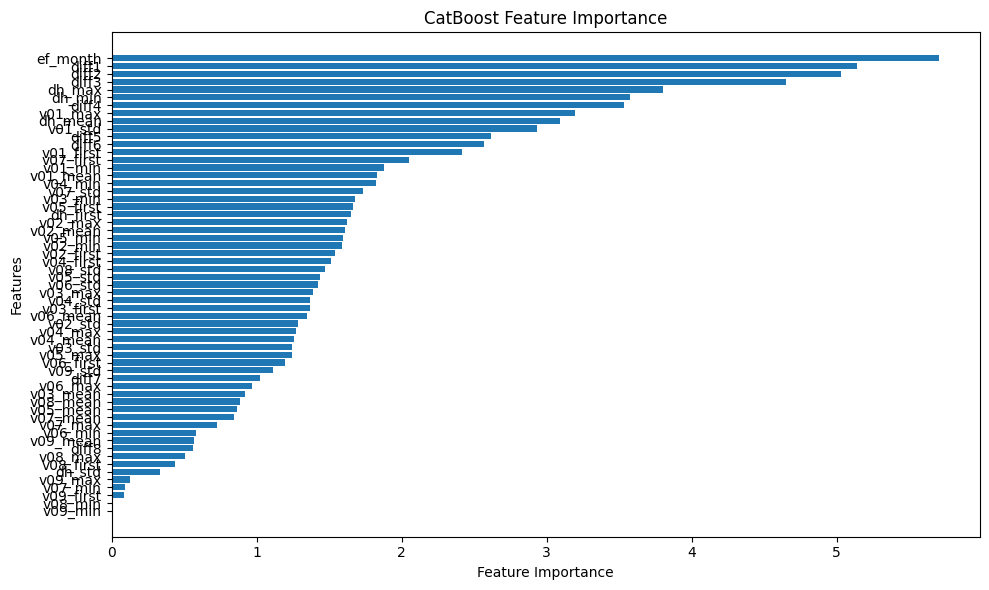

In [433]:
feature_importance = cat.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx], align='center')
plt.yticks(np.arange(len(feature_importance)), X.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

In [498]:
def make_submission(model):
    test_df = pd.read_csv('rainfall_test.csv')
    test_df.columns = test_df.columns.str.replace('rainfall_test.', '', regex=False)
    data_df = pd.read_csv('sequential.csv')
    columns_drop = ['label','vv','Unnamed: 0']
    data_df = data_df.drop(columns = columns_drop)
    answer_df = test_df[data_df.columns]
    le_ef_month = LabelEncoder()
    answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
    answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
    answer_df['v01'] = answer_df['v01']/100
    answer_df['v02'] = answer_df['v02']/100
    answer_df['v03'] = answer_df['v03']/100
    answer_df['v04'] = answer_df['v04']/100
    answer_df['v05'] = answer_df['v05']/100
    answer_df['v06'] = answer_df['v06']/100
    answer_df['v07'] = answer_df['v07']/100
    answer_df['v08'] = answer_df['v08']/100
    answer_df['v09'] = answer_df['v09']/100
    prob_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09','dh']
    index_column = ['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']
    answer_agg = answer_df.groupby(index_column)[prob_column].agg(['mean', 'std', 'min', 'max', 'first'])
    answer_agg.columns = ['_'.join(x) for x in answer_agg.columns]
    answer_first = answer_df.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']).head(1)
    answer_agg.index= answer_first.index
    answer_agg = answer_agg.fillna(0)
    answer_agg['diff1']=answer_agg['v01_first']-answer_agg['v02_first']
    answer_agg['diff2']=answer_agg['v02_first']-answer_agg['v03_first']
    answer_agg['diff3']=answer_agg['v03_first']-answer_agg['v04_first']
    answer_agg['diff4']=answer_agg['v04_first']-answer_agg['v05_first']
    answer_agg['diff5']=answer_agg['v05_first']-answer_agg['v06_first']
    answer_agg['diff6']=answer_agg['v06_first']-answer_agg['v07_first']
    answer_agg['diff7']=answer_agg['v07_first']-answer_agg['v08_first']
    answer_agg['diff8']=answer_agg['v08_first']-answer_agg['v09_first']
    answer_agg['ef_month'] = answer_first['ef_month']
    answer_agg = answer_agg[X.columns]
    answer = model.predict(answer_agg)
    answer_agg['class_interval']=answer
    answer_df['class_interval'] = answer_df.index.map(answer_agg['class_interval'])
    answer_df['class_interval'] = answer_df.groupby(['stn4contest','ef_year','ef_month','ef_day','ef_hour'])['class_interval'].fillna(method='ffill')
    test_df['class_interval']=answer_df['class_interval']
    return test_df

In [501]:
submission_df.to_csv('240183_v2.csv',index=False)

In [544]:
cat_SMOTE_submission = make_submission(cat)

C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\309351614.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\309351614.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_17308\309351614.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [546]:
cat_SMOTE_submission.to_csv('240183_v3.csv',index=False)
# 0.095

AutoEncoder

In [557]:
import pandas as pd  
import numpy as np 
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import MinMaxScaler  
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt 
import seaborn as sns 
from keras.layers import Input, Dense 
from keras.models import Model, Sequential 
from keras import regularizers 

In [571]:
def tsne_plot(x, y):   
    tsne = TSNE(n_components = 2, random_state = 0) 
      
    # Reducing the dimensionality of the data 
    X_transformed = tsne.fit_transform(x) 
  
    plt.figure(figsize =(12, 8)) 
      
    # Building the scatter plot for each class
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#123456', '#abcdef', '#aabbcc']
    labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
    for i in range(10):
        plt.scatter(X_transformed[np.where(y == i), 0],  
                    X_transformed[np.where(y == i), 1], 
                    marker ='o', color = colors[i], linewidth ='1', 
                    alpha = 0.8, label = labels[i]) 
  
    # Specifying the location of the legend 
    plt.legend(loc ='best') 
      
    # Plotting the reduced data 
    plt.show()

In [574]:
tsne = TSNE(n_components = 2, random_state = 0) 
    # Reducing the dimensionality of the data 
X_transformed = tsne.fit_transform(X)

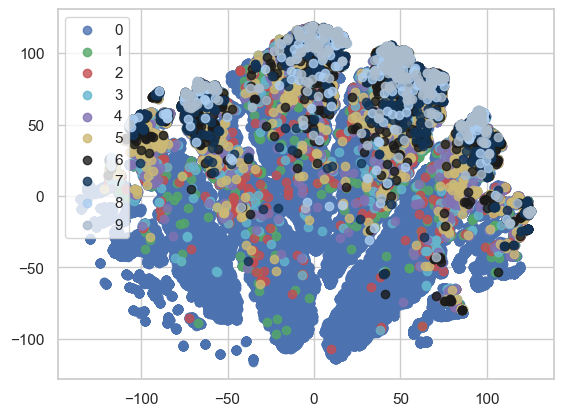

In [596]:
for i in range(10):
    plt.scatter(X_transformed[np.where(y == i), 0],  
                X_transformed[np.where(y == i), 1], 
                marker ='o', color = colors[i], 
                alpha = 0.8, label = labels[i]) 
plt.legend(loc = 'best')
plt.show()

Noise 제거 => 안하는게 낫다

In [83]:
def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf

def model_evaluation(y_pred,y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted') 
    clf = clf_eval(y_pred,y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    return clf

In [125]:
check_df = num_agg.copy()
check_df['class_interval']=first_df['class_interval']
check_df[(check_df['v01_min']>=0.5) & (check_df['class_interval']==0)]
indices_to_drop1 = check_df[(check_df['v01_min'] >=0.9) & (check_df['class_interval'] == 0)].index
indices_to_drop2 = check_df[(check_df['v01_max']<=0.1) & (check_df['class_interval']!=0)].index
check_df = check_df.drop(indices_to_drop1)
check_df = check_df.drop(indices_to_drop2)

In [202]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [288]:
from catboost import CatBoostClassifier


best_cat_params = {'iterations': 455, 'depth': 10, 'learning_rate': 0.22728295299413886}
cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'])

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
X = num_agg.fillna(0)
y = first_df['class_interval']

X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat.fit(X_train,y_train)
y_pred = cat.predict(X_test)

0:	learn: 1.0574651	total: 791ms	remaining: 5m 59s
1:	learn: 0.8852500	total: 1.86s	remaining: 7m 1s
2:	learn: 0.7787920	total: 2.69s	remaining: 6m 46s
3:	learn: 0.7060808	total: 3.57s	remaining: 6m 42s
4:	learn: 0.6538399	total: 4.36s	remaining: 6m 32s
5:	learn: 0.6135468	total: 5.14s	remaining: 6m 24s
6:	learn: 0.5837734	total: 5.92s	remaining: 6m 18s
7:	learn: 0.5605548	total: 6.64s	remaining: 6m 10s
8:	learn: 0.5445833	total: 7.41s	remaining: 6m 7s
9:	learn: 0.5305012	total: 8.18s	remaining: 6m 3s
10:	learn: 0.5190909	total: 8.94s	remaining: 6m
11:	learn: 0.5095596	total: 9.72s	remaining: 5m 58s
12:	learn: 0.5011706	total: 10.5s	remaining: 5m 56s
13:	learn: 0.4938324	total: 11.3s	remaining: 5m 54s
14:	learn: 0.4868731	total: 12s	remaining: 5m 53s
15:	learn: 0.4813829	total: 12.8s	remaining: 5m 50s
16:	learn: 0.4767158	total: 13.5s	remaining: 5m 48s
17:	learn: 0.4728218	total: 14.3s	remaining: 5m 46s
18:	learn: 0.4692670	total: 15s	remaining: 5m 44s
19:	learn: 0.4651037	total: 15.8s

In [295]:
# Bagging => worse

from sklearn.ensemble import BaggingClassifier
bagging_model = BaggingClassifier(base_estimator=cat, n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)

c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0:	learn: 1.0594096	total: 798ms	remaining: 6m 2s
1:	learn: 0.8898421	total: 1.63s	remaining: 6m 9s
2:	learn: 0.7812215	total: 2.42s	remaining: 6m 4s
3:	learn: 0.7053337	total: 3.21s	remaining: 6m 1s
4:	learn: 0.6503498	total: 4.03s	remaining: 6m 3s
5:	learn: 0.6096474	total: 4.85s	remaining: 6m 2s
6:	learn: 0.5775613	total: 5.76s	remaining: 6m 8s
7:	learn: 0.5546050	total: 6.46s	remaining: 6m 1s
8:	learn: 0.5369358	total: 7.18s	remaining: 5m 55s
9:	learn: 0.5203791	total: 7.93s	remaining: 5m 53s
10:	learn: 0.5088525	total: 8.68s	remaining: 5m 50s
11:	learn: 0.4973421	total: 9.46s	remaining: 5m 49s
12:	learn: 0.4870479	total: 10.2s	remaining: 5m 46s
13:	learn: 0.4792658	total: 11s	remaining: 5m 47s
14:	learn: 0.4716124	total: 11.8s	remaining: 5m 47s
15:	learn: 0.4661732	total: 12.6s	remaining: 5m 46s
16:	learn: 0.4591437	total: 13.4s	remaining: 5m 45s
17:	learn: 0.4539385	total: 14.2s	remaining: 5m 44s
18:	learn: 0.4476194	total: 14.9s	remaining: 5m 42s
19:	learn: 0.4436481	total: 15.7

BaggingClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x00000214C42916D0>,
                  random_state=42)

In [298]:
y_bagging = bagging_model.predict(X_test)
model_evaluation(y_bagging,y_test)

Accuracy: 0.8588197355691712
Precision: 0.8015640194983424
Recall: 0.8588197355691712


0.11519805982215037

In [302]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# stacking
cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'])
cat_1 = CatBoostClassifier(iterations=471, depth=8, learning_rate=0.164)
cat_2 = CatBoostClassifier(iterations=294, depth=9, learning_rate=0.278)
cat_3 = CatBoostClassifier(iterations=457, depth=9, learning_rate=0.12)

stacking_model = StackingClassifier(
    estimators=[('cat', cat), ('cat_1', cat_1), ('cat_2',cat_2),('cat_3',cat_3)],
    final_estimator=LogisticRegression(multi_class='multinomial', solver='lbfgs')
)

stacking_model.fit(X_train, y_train)

0:	learn: 1.0574651	total: 754ms	remaining: 5m 42s
1:	learn: 0.8852500	total: 1.51s	remaining: 5m 42s
2:	learn: 0.7787920	total: 2.32s	remaining: 5m 49s
3:	learn: 0.7060808	total: 3.1s	remaining: 5m 49s
4:	learn: 0.6538399	total: 3.9s	remaining: 5m 51s
5:	learn: 0.6135468	total: 4.74s	remaining: 5m 54s
6:	learn: 0.5837734	total: 5.57s	remaining: 5m 56s
7:	learn: 0.5605548	total: 6.54s	remaining: 6m 5s
8:	learn: 0.5445833	total: 7.36s	remaining: 6m 4s
9:	learn: 0.5305012	total: 8.1s	remaining: 6m
10:	learn: 0.5190909	total: 8.86s	remaining: 5m 57s
11:	learn: 0.5095596	total: 9.6s	remaining: 5m 54s
12:	learn: 0.5011706	total: 10.4s	remaining: 5m 53s
13:	learn: 0.4938324	total: 11.2s	remaining: 5m 51s
14:	learn: 0.4868731	total: 12s	remaining: 5m 53s
15:	learn: 0.4813829	total: 12.8s	remaining: 5m 50s
16:	learn: 0.4767158	total: 13.5s	remaining: 5m 48s
17:	learn: 0.4728218	total: 14.3s	remaining: 5m 47s
18:	learn: 0.4692670	total: 15.1s	remaining: 5m 46s
19:	learn: 0.4651037	total: 15.9s	

c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x0000021439FF37F0>),
                               ('cat_1',
                                <catboost.core.CatBoostClassifier object at 0x0000021439FF3820>),
                               ('cat_2',
                                <catboost.core.CatBoostClassifier object at 0x0000021439FF3400>),
                               ('cat_3',
                                <catboost.core.CatBoostClassifier object at 0x0000021439FF3100>)],
                   final_estimator=LogisticRegression(multi_class='multinomial'))

In [303]:
model_evaluation(y_pred,y_test)

Accuracy: 0.8584327636246372
Precision: 0.8065745195379113
Recall: 0.8584327636246372


0.12965900079302142

In [270]:
X_train.columns

Index(['v01_mean', 'v01_median', 'v01_min', 'v01_max', 'v01_first', 'v01_last',
       'v02_mean', 'v02_median', 'v02_min', 'v02_max', 'v02_first', 'v02_last',
       'v03_mean', 'v03_median', 'v03_min', 'v03_max', 'v03_first', 'v03_last',
       'v04_mean', 'v04_median', 'v04_min', 'v04_max', 'v04_first', 'v04_last',
       'v05_mean', 'v05_median', 'v05_min', 'v05_max', 'v05_first', 'v05_last',
       'v06_mean', 'v06_median', 'v06_min', 'v06_max', 'v06_first', 'v06_last',
       'v07_mean', 'v07_median', 'v07_min', 'v07_max', 'v07_first', 'v07_last',
       'v08_mean', 'v08_median', 'v08_min', 'v08_max', 'v08_first', 'v08_last',
       'v09_mean', 'v09_median', 'v09_min', 'v09_max', 'v09_first', 'v09_last',
       'dh_mean', 'dh_median', 'dh_min', 'dh_max', 'dh_first', 'dh_last',
       'ef_month', 'ef_hour', 'ef_day', 'diff1', 'diff2', 'diff3', 'diff4',
       'diff5', 'diff6', 'diff7', 'diff8'],
      dtype='object')

In [239]:
feature_importance = cat.get_feature_importance()
feature_importances = list(zip(feature_importance,X.columns))

In [281]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


best_rf_params = {'n_estimators': 111, 'max_depth': 25}
best_lgbm_params = {'num_leaves': 69, 'max_depth': 49, 'learning_rate': 0.07666414363854966, 'n_estimators': 96}
best_xgb_params = {'n_estimators': 98, 'max_depth': 14, 'learning_rate': 0.09892938180643206, 'subsample': 0.5863193004666019, 'colsample_bytree': 0.515216684370245}
best_cat_params = {'iterations': 455, 'depth': 10, 'learning_rate': 0.22728295299413886}

rf = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'], max_depth=best_rf_params['max_depth'])
lgbm = LGBMClassifier(num_leaves=best_lgbm_params['num_leaves'], max_depth=best_lgbm_params['max_depth'], learning_rate=best_lgbm_params['learning_rate'], n_estimators=best_lgbm_params['n_estimators'],force_row_wise=True)
xgb = XGBClassifier(n_estimators=best_xgb_params['n_estimators'], max_depth=best_xgb_params['max_depth'], learning_rate=best_xgb_params['learning_rate'], subsample=best_xgb_params['subsample'], colsample_bytree=best_xgb_params['colsample_bytree'])
cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'])

In [248]:
rf.fit(X_train,y_train)
lgbm.fit(X_train,y_train)
xgb.fit(X_train,y_train)

[LightGBM] [Info] Total Bins 7304
[LightGBM] [Info] Number of data points in the train set: 62018, number of used features: 70
[LightGBM] [Info] Start training from score -0.168346
[LightGBM] [Info] Start training from score -4.196775
[LightGBM] [Info] Start training from score -3.753794
[LightGBM] [Info] Start training from score -3.836249
[LightGBM] [Info] Start training from score -3.770450
[LightGBM] [Info] Start training from score -3.551936
[LightGBM] [Info] Start training from score -3.955153
[LightGBM] [Info] Start training from score -4.260956
[LightGBM] [Info] Start training from score -5.215097
[LightGBM] [Info] Start training from score -5.407559


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.515216684370245, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09892938180643206,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=98, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [253]:
from sklearn.ensemble import VotingClassifier
ensemble_weight = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
                        voting='soft', weights=[0.3, 0.3,0.4])
ensemble_weight.fit(X_train, y_train)

y_pred = ensemble_weight.predict(X_test)
model_evaluation(y_pred, y_test)

0:	learn: 1.0387253	total: 721ms	remaining: 5m 27s
1:	learn: 0.8685481	total: 1.5s	remaining: 5m 39s
2:	learn: 0.7626789	total: 2.25s	remaining: 5m 38s
3:	learn: 0.6891762	total: 3.11s	remaining: 5m 50s
4:	learn: 0.6360446	total: 3.96s	remaining: 5m 56s
5:	learn: 0.5981875	total: 4.72s	remaining: 5m 53s
6:	learn: 0.5685151	total: 5.48s	remaining: 5m 51s
7:	learn: 0.5459812	total: 6.32s	remaining: 5m 52s
8:	learn: 0.5276635	total: 7.22s	remaining: 5m 57s
9:	learn: 0.5129974	total: 8.09s	remaining: 5m 59s
10:	learn: 0.5001527	total: 9.12s	remaining: 6m 8s
11:	learn: 0.4910200	total: 10.2s	remaining: 6m 17s
12:	learn: 0.4818794	total: 11.3s	remaining: 6m 25s
13:	learn: 0.4732741	total: 12.4s	remaining: 6m 31s
14:	learn: 0.4668619	total: 13.5s	remaining: 6m 35s
15:	learn: 0.4605308	total: 14.5s	remaining: 6m 38s
16:	learn: 0.4557750	total: 15.4s	remaining: 6m 37s
17:	learn: 0.4527300	total: 16.3s	remaining: 6m 34s
18:	learn: 0.4503094	total: 17.1s	remaining: 6m 32s
19:	learn: 0.4464750	tot

0.12444444444444444

In [249]:
# ef_hour, ef_day 추가한 data + catboost 0.13나온 기술통계량 column
rf_pred = rf.predict(X_test)
lgbm_pred = lgbm.predict(X_test)
xgb_pred = xgb.predict(X_test)

In [250]:
model_evaluation(rf_pred,y_test)

Accuracy: 0.8595291841341502
Precision: 0.8037347865525866
Recall: 0.8595291841341502


0.11928831378892034

In [251]:
model_evaluation(lgbm_pred,y_test)

Accuracy: 0.8569493711705901
Precision: 0.8018116004708912
Recall: 0.8569493711705901


0.11421725239616613

In [252]:
model_evaluation(xgb_pred,y_test)

Accuracy: 0.8595291841341502
Precision: 0.8053602059764323
Recall: 0.8595291841341502


0.12212817412333736

In [265]:
feature_importances.sort()
feature_importances

[(1.918924360935061e-06, 'v09_min'),
 (0.0005410880425614278, 'v08_min'),
 (0.00477547731031936, 'v09_median'),
 (0.044864263375915196, 'v09_last'),
 (0.04745069029476918, 'v09_first'),
 (0.051398246973302135, 'v07_min'),
 (0.10656007521247232, 'v08_median'),
 (0.21149687951573518, 'v08_last'),
 (0.24455749568946236, 'dh_last'),
 (0.28953767239046163, 'v08_first'),
 (0.37866973019269795, 'v07_median'),
 (0.44871286980658115, 'v06_min'),
 (0.4702691326908206, 'diff8'),
 (0.5027924103902452, 'v02_max'),
 (0.5799970137294719, 'v08_max'),
 (0.5884593022637561, 'v04_mean'),
 (0.6352758909677636, 'v03_mean'),
 (0.6359515047059217, 'v06_median'),
 (0.6381393874348329, 'v04_median'),
 (0.7008782282737857, 'v02_mean'),
 (0.7137261968294022, 'v05_median'),
 (0.7193535171442077, 'v03_median'),
 (0.7201959234105667, 'dh_median'),
 (0.7229767105872399, 'v01_max'),
 (0.7521359460044988, 'v07_max'),
 (0.7760071848400832, 'v03_max'),
 (0.7894394342784447, 'v09_mean'),
 (0.7992250943554497, 'v07_last')

In [210]:
X.columns

Index(['v01_sum', 'v01_mean', 'v01_median', 'v01_min', 'v01_max', 'v01_std',
       'v01_sem', 'v01_first', 'v01_last', 'v02_sum', 'v02_mean', 'v02_median',
       'v02_min', 'v02_max', 'v02_std', 'v02_sem', 'v02_first', 'v02_last',
       'v03_sum', 'v03_mean', 'v03_median', 'v03_min', 'v03_max', 'v03_std',
       'v03_sem', 'v03_first', 'v03_last', 'v04_sum', 'v04_mean', 'v04_median',
       'v04_min', 'v04_max', 'v04_std', 'v04_sem', 'v04_first', 'v04_last',
       'v05_sum', 'v05_mean', 'v05_median', 'v05_min', 'v05_max', 'v05_std',
       'v05_sem', 'v05_first', 'v05_last', 'v06_sum', 'v06_mean', 'v06_median',
       'v06_min', 'v06_max', 'v06_std', 'v06_sem', 'v06_first', 'v06_last',
       'v07_sum', 'v07_mean', 'v07_median', 'v07_min', 'v07_max', 'v07_std',
       'v07_sem', 'v07_first', 'v07_last', 'v08_sum', 'v08_mean', 'v08_median',
       'v08_min', 'v08_max', 'v08_std', 'v08_sem', 'v08_first', 'v08_last',
       'v09_sum', 'v09_mean', 'v09_median', 'v09_min', 'v09_max', 'v

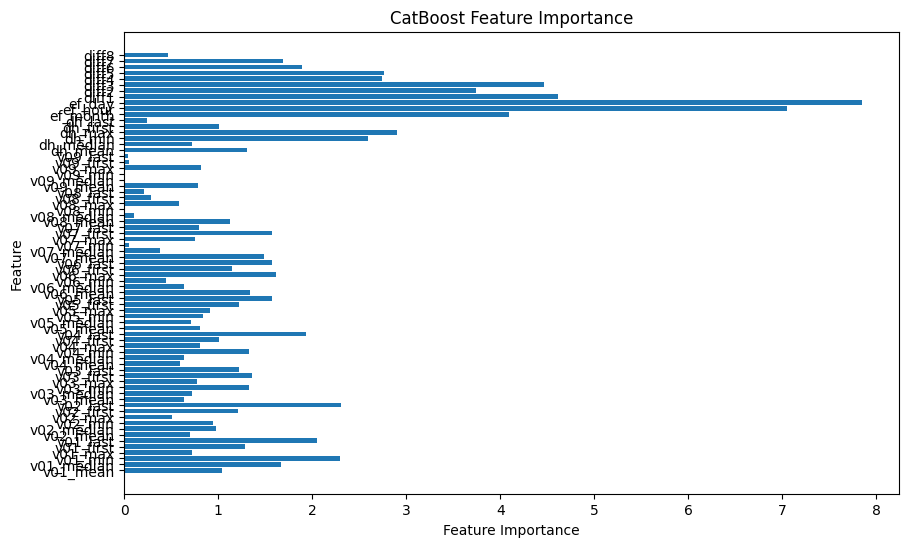

In [264]:
import matplotlib.pyplot as plt
feature_names = X.columns
features_with_importances = list(zip(feature_names, feature_importance))
features_with_importances.sort(key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.show()

In [255]:
X.columns

Index(['v01_mean', 'v01_median', 'v01_min', 'v01_max', 'v01_first', 'v01_last',
       'v02_mean', 'v02_median', 'v02_min', 'v02_max', 'v02_first', 'v02_last',
       'v03_mean', 'v03_median', 'v03_min', 'v03_max', 'v03_first', 'v03_last',
       'v04_mean', 'v04_median', 'v04_min', 'v04_max', 'v04_first', 'v04_last',
       'v05_mean', 'v05_median', 'v05_min', 'v05_max', 'v05_first', 'v05_last',
       'v06_mean', 'v06_median', 'v06_min', 'v06_max', 'v06_first', 'v06_last',
       'v07_mean', 'v07_median', 'v07_min', 'v07_max', 'v07_first', 'v07_last',
       'v08_mean', 'v08_median', 'v08_min', 'v08_max', 'v08_first', 'v08_last',
       'v09_mean', 'v09_median', 'v09_min', 'v09_max', 'v09_first', 'v09_last',
       'dh_mean', 'dh_median', 'dh_min', 'dh_max', 'dh_first', 'dh_last',
       'ef_month', 'ef_hour', 'ef_day', 'diff1', 'diff2', 'diff3', 'diff4',
       'diff5', 'diff6', 'diff7', 'diff8'],
      dtype='object')

In [310]:
def make_submission(model):
    test_df = pd.read_csv('rainfall_test.csv')
    test_df.columns = test_df.columns.str.replace('rainfall_test.', '', regex=False)
    data_df = pd.read_csv('sequential.csv')
    columns_drop = ['label','vv','Unnamed: 0']
    data_df = data_df.drop(columns = columns_drop)
    answer_df = test_df[data_df.columns]
    le_ef_month = LabelEncoder()
    answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
    answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
    answer_df['v01'] = answer_df['v01']/100
    answer_df['v02'] = answer_df['v02']/100
    answer_df['v03'] = answer_df['v03']/100
    answer_df['v04'] = answer_df['v04']/100
    answer_df['v05'] = answer_df['v05']/100
    answer_df['v06'] = answer_df['v06']/100
    answer_df['v07'] = answer_df['v07']/100
    answer_df['v08'] = answer_df['v08']/100
    answer_df['v09'] = answer_df['v09']/100
    prob_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09','dh']
    index_column = ['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']
    answer_agg = answer_df.groupby(index_column)[prob_column].agg(['mean', 'median', 'min', 'max', 'first', 'last','std'])
    answer_agg.columns = ['_'.join(x) for x in answer_agg.columns]
    answer_first = answer_df.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']).head(1)
    answer_agg.index= answer_first.index
    answer_agg = answer_agg.fillna(0)
    answer_agg['diff1']=answer_agg['v01_first']-answer_agg['v02_first']
    answer_agg['diff2']=answer_agg['v02_first']-answer_agg['v03_first']
    answer_agg['diff3']=answer_agg['v03_first']-answer_agg['v04_first']
    answer_agg['diff4']=answer_agg['v04_first']-answer_agg['v05_first']
    answer_agg['diff5']=answer_agg['v05_first']-answer_agg['v06_first']
    answer_agg['diff6']=answer_agg['v06_first']-answer_agg['v07_first']
    answer_agg['diff7']=answer_agg['v07_first']-answer_agg['v08_first']
    answer_agg['diff8']=answer_agg['v08_first']-answer_agg['v09_first']
    answer_agg['ef_month'] = answer_first['ef_month']
    answer_agg['ef_day'] = answer_first['ef_day']
    answer_agg['ef_hour'] = answer_first['ef_hour']
    answer_agg = answer_agg[X.columns]
    answer = model.predict(answer_agg)
    answer_agg['class_interval']=answer
    answer_df['class_interval'] = answer_df.index.map(answer_agg['class_interval'])
    answer_df['class_interval'] = answer_df.groupby(['stn4contest','ef_year','ef_month','ef_day','ef_hour'])['class_interval'].fillna(method='ffill')
    test_df['class_interval']=answer_df['class_interval']
    return test_df

In [261]:
ef_cat_df = make_submission(cat)

C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\1228067060.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\1228067060.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\1228067060.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [355]:
cat_reg_smoteen_df = make_submission(cat_reg)

C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\75938199.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\75938199.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\75938199.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [459]:
cat_reg_smoteen_df[cat_reg_smoteen_df['class_interval']==0]
cat_reg_smoteen_df.to_csv('240183_smoteen_reg.csv',index=False)

In [409]:
cat_reg_smoteen_df[cat_reg_smoteen_df['class_interval']==2]

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,v07,v08,v09,class_interval
29,D,5,1,9,STN031,90,D,5,5,3,93,93,91,80,73,45,17,0,0,2.0
32,D,5,1,9,STN031,99,D,5,5,12,99,95,87,78,68,19,1,0,0,2.0
34,D,5,1,9,STN031,105,D,5,5,18,100,100,92,82,65,35,8,0,0,2.0
105,D,5,1,21,STN031,78,D,5,5,3,100,100,97,92,84,39,9,0,0,2.0
108,D,5,1,21,STN031,87,D,5,5,12,96,94,92,84,55,27,3,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120819,D,9,23,21,STN035,60,D,9,26,9,26,22,9,6,2,0,0,0,0,2.0
120895,D,9,24,9,STN035,48,D,9,26,9,28,27,12,4,0,0,0,0,0,2.0
120971,D,9,24,21,STN035,36,D,9,26,9,59,46,25,15,7,4,0,0,0,2.0
121047,D,9,25,9,STN035,24,D,9,26,9,57,46,33,30,12,0,0,0,0,2.0


In [399]:
cat_smote_df = make_submission(cat_SMOTE)

C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\75938199.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\75938199.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_30512\75938199.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [423]:
cat_smote_df.to_csv('240183_smote_reg.csv',index=False)

In [430]:
cat_smote_df[cat_smote_df['class_interval']==5]

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,v07,v08,v09,class_interval
35,D,5,1,9,STN031,108,D,5,5,21,95,91,80,64,43,19,3,0,0,5.0
36,D,5,1,9,STN031,111,D,5,6,0,89,77,60,44,29,15,4,0,0,5.0
37,D,5,1,9,STN031,114,D,5,6,3,81,74,61,33,21,8,4,0,0,5.0
38,D,5,1,9,STN031,117,D,5,6,6,69,54,41,31,9,4,0,0,0,5.0
39,D,5,1,9,STN031,120,D,5,6,9,56,49,31,18,7,0,0,0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120246,D,9,20,9,STN035,21,D,9,21,6,57,47,31,13,4,0,0,0,0,5.0
120248,D,9,20,9,STN035,27,D,9,21,12,81,64,36,23,5,0,0,0,0,5.0
120322,D,9,20,21,STN035,9,D,9,21,6,63,51,29,16,1,0,0,0,0,5.0
120324,D,9,20,21,STN035,15,D,9,21,12,63,40,11,2,0,0,0,0,0,5.0


In [456]:
cat_reg_df.to_csv('240183_smoteen.csv')

In [455]:
cat_reg_df[cat_reg_df['class_interval']==1]

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,v07,v08,v09,class_interval
319,D,5,2,21,STN031,240,D,5,12,21,6,6,3,2,2,0,0,0,0,1.0
395,D,5,3,9,STN031,228,D,5,12,21,25,21,16,9,3,1,0,0,0,1.0
471,D,5,3,21,STN031,216,D,5,12,21,22,17,14,11,7,1,0,0,0,1.0
477,D,5,3,21,STN031,234,D,5,13,15,31,25,17,11,6,0,0,0,0,1.0
547,D,5,4,9,STN031,204,D,5,12,21,14,11,4,2,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118898,D,9,11,21,STN035,57,D,9,14,6,99,97,90,81,68,29,4,0,0,1.0
118974,D,9,12,9,STN035,45,D,9,14,6,84,74,53,29,14,4,0,0,0,1.0
119050,D,9,12,21,STN035,33,D,9,14,6,90,83,63,44,19,2,0,0,0,1.0
119126,D,9,13,9,STN035,21,D,9,14,6,96,91,79,59,29,0,0,0,0,1.0


In [334]:
cm = confusion_matrix(y_pred,y_test)
print(cm)

[[11535    67    97    54    54    42    16     5     1     4]
 [  298    20    36    33    19    20    13     2     0     1]
 [  402    34    66    45    40    29    13    10     3     1]
 [  333    50    52    51    48    44    20     5     1     5]
 [  230    20    53    53    76    58    31     8     7     6]
 [  227    17    49    63    73   131    74    52    12    11]
 [   53     5     9    18    40    72    75    47    13     7]
 [   32     2     8     6    16    23    42    51    22    14]
 [    9     0     2     2     2     4     2    16    11    11]
 [    9     0     1     0     2     4     4    24    11    16]]


In [215]:
num_agg.columns

Index(['v01_sum', 'v01_mean', 'v01_median', 'v01_min', 'v01_max', 'v01_std',
       'v01_sem', 'v01_first', 'v01_last', 'v02_sum',
       ...
       'ef_hour', 'ef_day', 'diff1', 'diff2', 'diff3', 'diff4', 'diff5',
       'diff6', 'diff7', 'diff8'],
      dtype='object', length=101)

In [263]:
ef_cat_df.to_csv('240183_efhour.csv',index=False)